In [1]:
import copy
import itertools
import numpy as np
import h5py
import scipy
import sys
import tqdm
import verdict
import os
import unyt

In [2]:
import matplotlib as mpl
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import palettable

In [3]:
import kalepy as kale

In [4]:
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.plot_data.plotting as plotting

In [5]:
import trove

# Load Data

In [6]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    variation = 'm12i_md',
)

In [7]:
data_filepath = os.path.join( pm['processed_data_dir'], 'summary.hdf5' )
data = verdict.Dict.from_hdf5( data_filepath )

In [8]:
h_param = .702

In [9]:
mvir = verdict.Dict({})
for key in tqdm.tqdm( data['n_tracked'].keys() ):
    
    pm_i = trove.link_params_to_config(
        '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
        variation = key,
    )
    
    h_data = halo_data.HaloData(
        data_dir = pm_i['halo_data_dir'],
        mt_kwargs = { 'tag': 'smooth' },
    )
    
    mvir[key] =  h_data.get_mt_data( 'Mvir', snums=[600] )[0]/h_param

100%|██████████| 14/14 [00:03<00:00,  3.73it/s]


# Extract Quantities

In [10]:
delta_thin_disk = (
    data['circularity']['thin_disk_fractions'].inner_item( -1 ) - 
    data['circularity']['thin_disk_fractions'].inner_item( 0 )
)

In [11]:
sigma_cosphi = data['cosphi']['84th_percentile'] - data['cosphi']['16th_percentile']
delta_sigma_cosphi = sigma_cosphi.inner_item( -1 ) - sigma_cosphi.inner_item( 0 )
negative_delta_sigma_cosphi = -1. * delta_sigma_cosphi
sigma_cosphi_ratio = sigma_cosphi.inner_item( 0 ) / sigma_cosphi.inner_item( -1 )

In [12]:
delta_pdf = data['cosphi']['pdf(cos theta=0)'].inner_item( -1 ) - data['cosphi']['pdf(cos theta=0)'].inner_item( 0 )
delta_q20 = data['cosphi']['q20'].inner_item( -1 ) - data['cosphi']['q20'].inner_item( 0 )
delta_q33 = data['cosphi']['q33'].inner_item( -1 ) - data['cosphi']['q33'].inner_item( 0 )
std_cosphi_ratio = data['cosphi']['std'].inner_item( 0 ) / data['cosphi']['std'].inner_item( -1 )

In [13]:
values = {
    'delta_thin_disk': delta_thin_disk,
    'median_R1e5K': data['R1e5K']['median'],
    'median_R1e5K_rgal': data['R1e5K_rgal']['median'],
    'thin_disk_frac': data['thin_disk_fraction'],
    'thin_disk_frac_recent': data['thin_disk_fraction_recent'],
    'mvir': mvir,
    'negative_delta_sigma_cosphi': negative_delta_sigma_cosphi,
    'sigma_cosphi_ratio': sigma_cosphi_ratio,
    'std_cosphi_ratio': std_cosphi_ratio,
    'delta_pdfcosphi': delta_pdf,
    'delta_q20': delta_q20,
    'delta_q33': delta_q33,
}

# Plot

## One Value per Axis

In [14]:
labels = {
    'delta_thin_disk': r'$\Delta f_{\rm thin}$',
    'median_R1e5K': r'median $R_{T=10^5\, {\rm K}}$ (kpc)',
    'median_R1e5K_rgal': r'median $R_{T=10^5\, {\rm K}}$ / $R_{\rm gal}$',
    'thin_disk_frac': r'$f_{\rm thin}(\star,z=0)$',
    'thin_disk_frac_recent': r'$f_{\rm thin}(\star,z=0,$ age<1 Gyr)',
    'mvir': r'$M_{\rm vir}(z=0)$ / $M_\odot$',
    'sigma_cosphi': r'$\sigma( \cos\theta )$',
    'negative_delta_sigma_cosphi': r'$\sigma_{\cos\theta,\,{\rm hot}}$ - $\sigma_{\cos\theta,\,{\rm cool}}$',
    'sigma_cosphi_ratio': r'$\sigma_{\cos\theta,\,{\rm hot}}$ / $\sigma_{\cos\theta,\,{\rm cool}}$',
    'std_cosphi_ratio': r'${\rm STD}_{\cos\theta,\,{\rm hot}}$ / ${\rm STD}_{\cos\theta,\,{\rm cool}}$',
    'delta_pdfcosphi': r'$\Delta {\rm PDF}(\cos\theta)$',
    'delta_q20': r'$\Delta q_{20}$',
    'delta_q33': r'$\Delta q_{33}$',
}

In [15]:
logscale = [ 'mvir', ]

In [16]:
markers = {
    'md': 'o',
    'cr': '^',
    'mhdcv': 'P',
    '': 's',
}

In [17]:
marker_labels = {
    'md': 'Hydro+',
    'cr': 'CR+',
    'mhdcv': 'MHD+',
    '': 'no metal diffusion',
}

In [18]:
# Automatic
value_keys = list( values.keys() )
combinations = itertools.combinations( value_keys, 3 )

In [19]:
# Manual
combinations = [
    ( 'sigma_cosphi_ratio', 'thin_disk_frac', 'mvir' ),
    ( 'sigma_cosphi_ratio', 'thin_disk_frac_recent', 'mvir' ),
    ( 'sigma_cosphi_ratio', 'thin_disk_frac_recent', 'median_R1e5K_rgal' ),
    ( 'negative_delta_sigma_cosphi', 'thin_disk_frac_recent', 'mvir' ),
    ( 'median_R1e5K', 'thin_disk_frac_recent', 'mvir' ),
    ( 'median_R1e5K_rgal', 'thin_disk_frac_recent', 'mvir' ),
    ( 'delta_pdfcosphi', 'thin_disk_frac_recent', 'mvir' ),
    ( 'delta_q20', 'thin_disk_frac_recent', 'mvir' ),
    ( 'delta_q33', 'thin_disk_frac_recent', 'mvir' ),
    ( 'std_cosphi_ratio', 'thin_disk_frac_recent', 'mvir' ),
    ( 'sigma_cosphi_ratio', 'thin_disk_frac_recent', 'delta_pdfcosphi' ),
    ( 'mvir', 'sigma_cosphi_ratio', 'thin_disk_frac', ),
    ( 'mvir', 'std_cosphi_ratio', 'thin_disk_frac', ),
    ( 'mvir', 'delta_pdfcosphi', 'thin_disk_frac', ),
]

In [20]:
custom_lims = {
    'median_R1e5K_rgal': [ 0, 4 ],
}

In [21]:
cmap = palettable.matplotlib.Viridis_20.mpl_colormap

In [22]:
def get_lim( vs, is_log, v_key, scale_upper=1. ):
    
    if v_key in custom_lims:
        return custom_lims[v_key]
    
    min_v = np.nanmin( vs.array() )
    if not is_log:
        min_v = min( 0, min_v )
        
    max_v = np.nanmax( vs.array() ) * scale_upper
                      
    return min_v, max_v

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/sigma_cosphi_ratio.thin_disk_frac.mvir.pdf
File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/sigma_cosphi_ratio.thin_disk_frac_recent.mvir.pdf
File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/sigma_cosphi_ratio.thin_disk_frac_recent.median_R1e5K_rgal.pdf
File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/negative_delta_sigma_cosphi.thin_disk_frac_recent.mvir.pdf
File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/median_R1e5K.thin_disk_frac_recent.mvir.pdf
File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/median_R1e5K_rgal.thin_disk_frac_recent.mvir.pdf
File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/delta_pdfcosphi.thin_disk_frac_recent.mvir.pdf
File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/

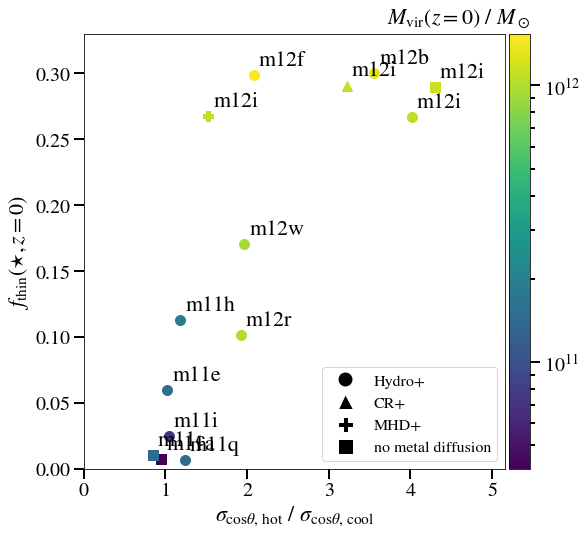

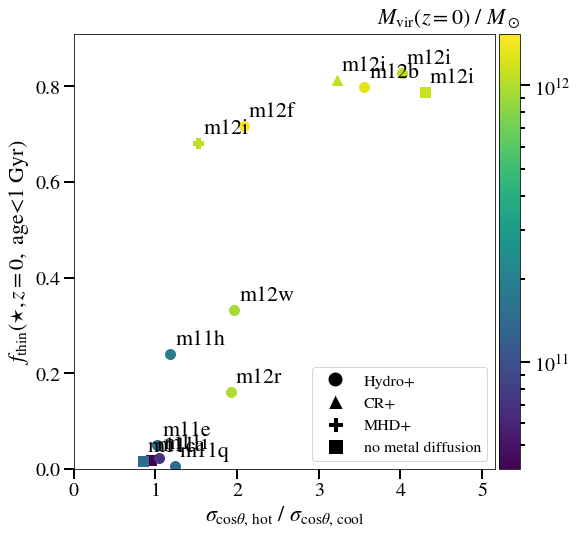

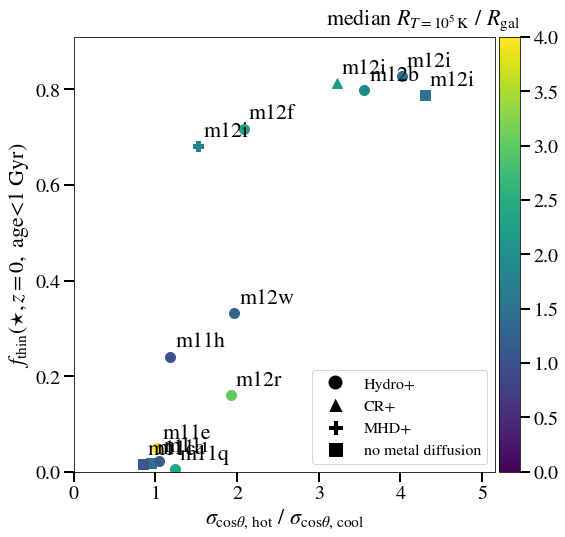

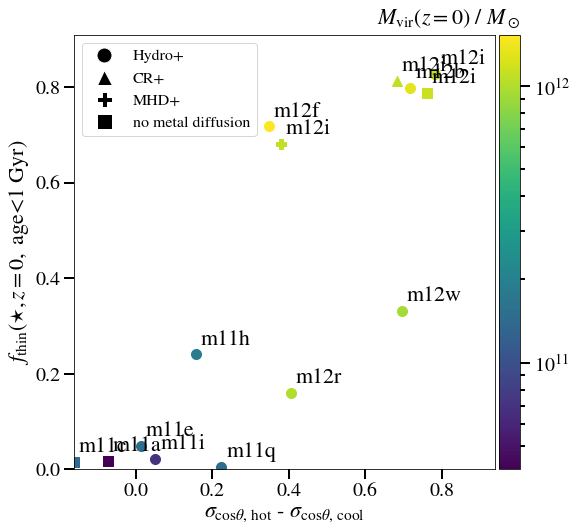

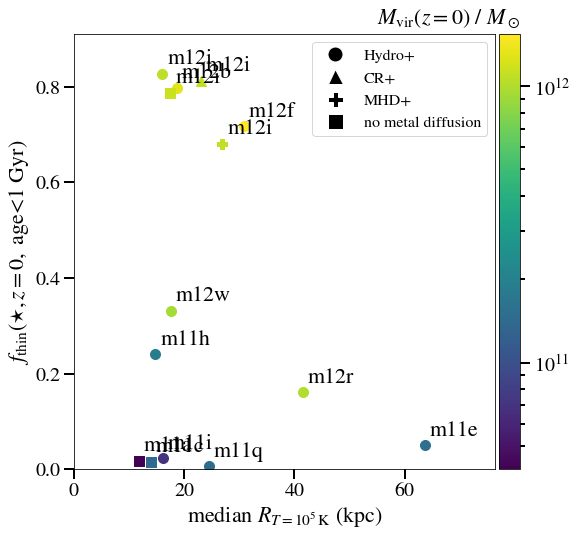

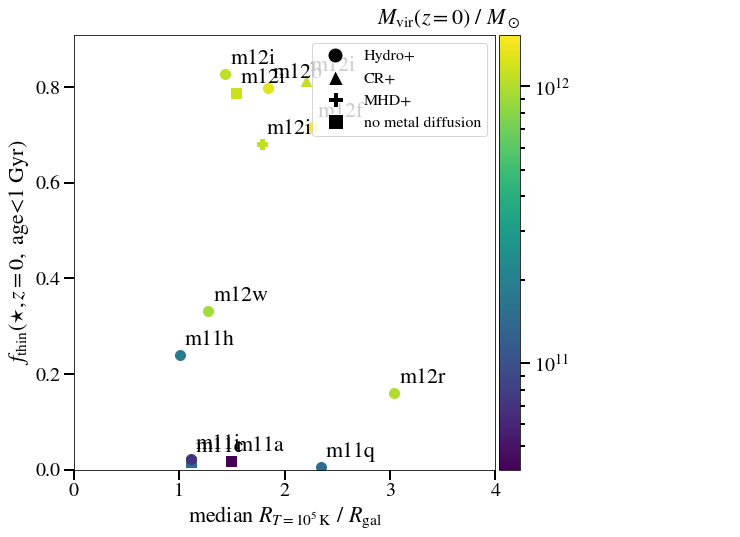

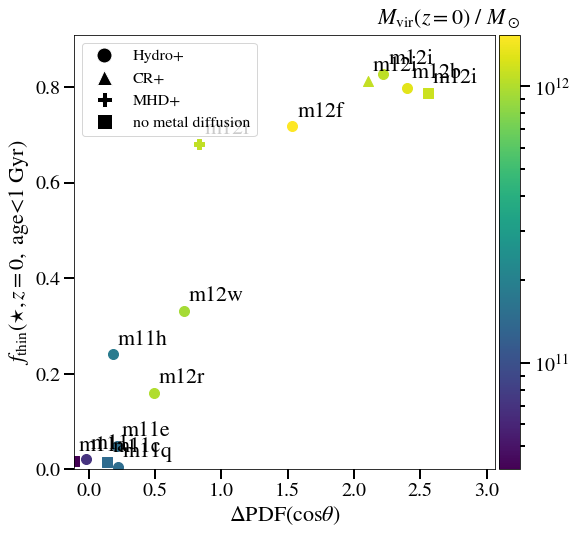

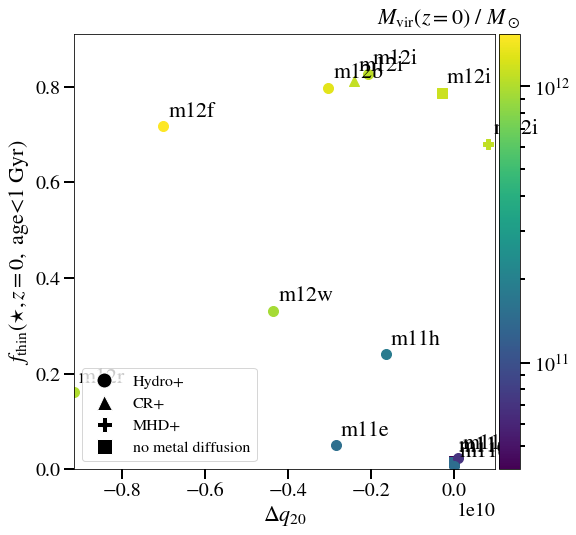

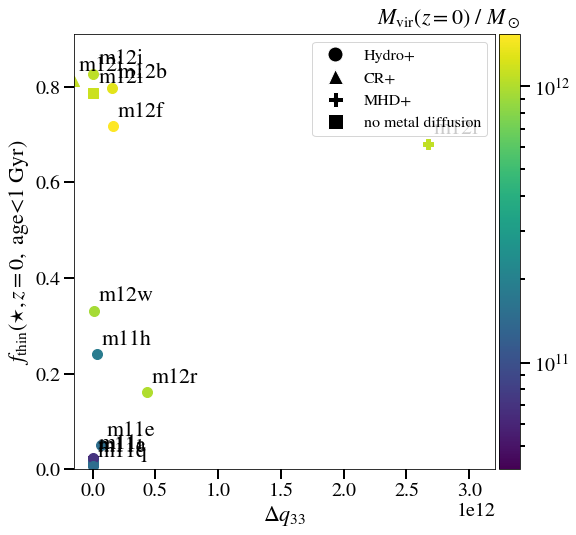

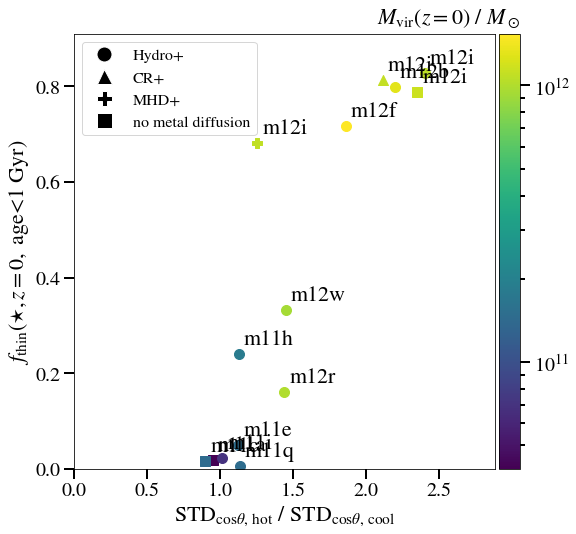

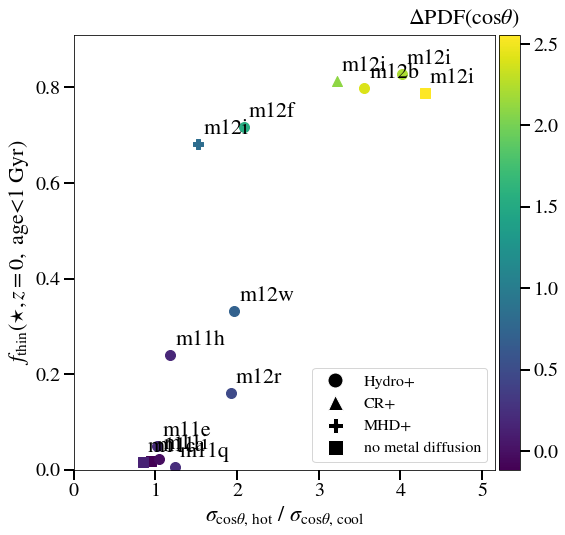

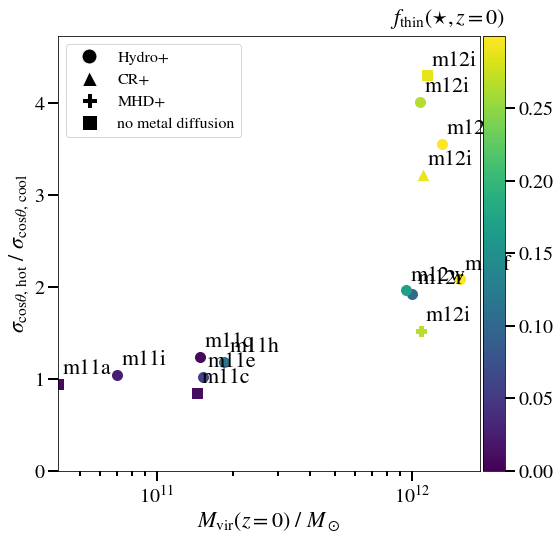

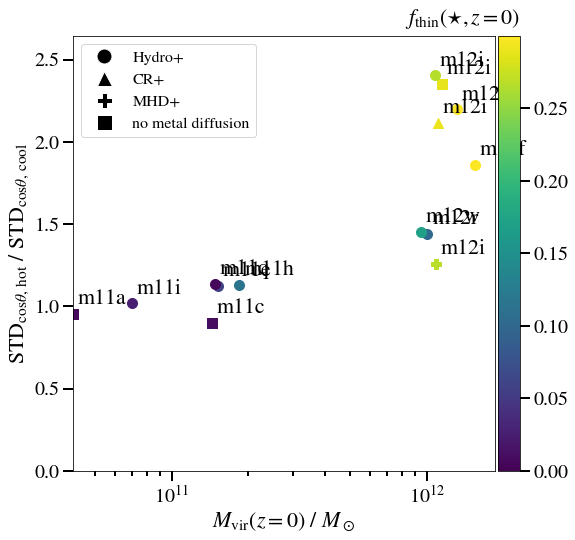

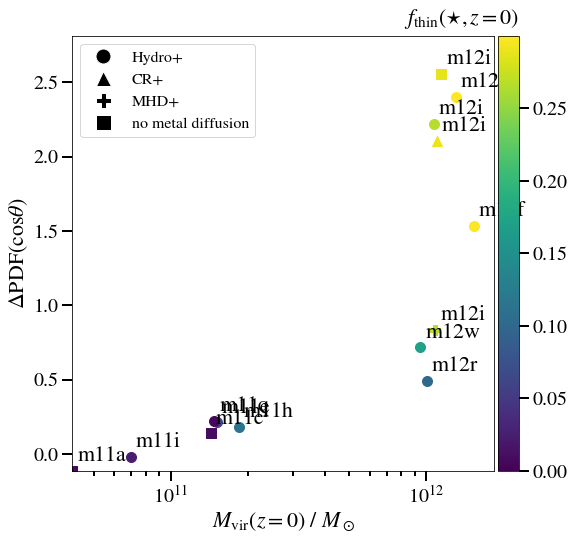

In [23]:
for i, (x_key, y_key, z_key) in enumerate( combinations ):
    
    xs = values[x_key]
    ys = values[y_key]
    zs = values[z_key]
    
    x_log = x_key in logscale
    y_log = y_key in logscale
    z_log = z_key in logscale
        
    x_lims = get_lim( xs, x_log, x_key, 1.2 )
    y_lims = get_lim( ys, y_log, y_key, 1.1 )
    z_lims = get_lim( zs, z_log, z_key, )

    fig = plt.figure( figsize=(8,8), facecolor='w' )
    ax = plt.gca()

    for key, x in xs.items():
        
        if np.isnan( x ):
            continue
        
        try:
            y = ys[key]
            z = zs[key]
        except KeyError:
            continue
        
        if '_' in key:
            sim_name, physics = key.split( '_' )
        else:
            sim_name = key
            physics = ''

        if not z_log:
            c_value = ( z - z_lims[0] ) / ( z_lims[1] - z_lims[0] )
        else:
            c_value = ( np.log10( z ) - np.log10( z_lims[0] ) ) / ( np.log10( z_lims[1] ) - np.log10( z_lims[0] ) )
        c = cmap( c_value )
            
        s = ax.scatter(
            x,
            y,
            s = 100,
            color = c,
            marker = markers[physics]
        )

        ax.annotate(
            s = sim_name,
            xy = ( x, y ),
            xytext = ( 5, 5 ),
            textcoords = 'offset points',
            fontsize = 22,
            ha = 'left',
            va = 'bottom',
        )
        
    ax.set_xlabel( labels[x_key], fontsize=22 )
    ax.set_ylabel( labels[y_key], fontsize=22 )
    
    if x_log:
        ax.set_xscale( 'log' )
    if y_log:
        ax.set_yscale( 'log' )
    
    ax.set_xlim( x_lims )
    ax.set_ylim( y_lims )
    
    # Legend
    legend_elements = [
        Line2D([0], [0], marker=markers[_], color='w', label=marker_labels[_], markerfacecolor='k', markersize=15)
        for _ in markers.keys()
    ]
    ax.legend(
        handles=legend_elements,
        prop = {'size': 16 },
    )
    
    # Colorbar
    if not z_log:
        norm_class = mpl.colors.Normalize
    else:
        norm_class = mpl.colors.LogNorm
    norm = norm_class(vmin=z_lims[0], vmax=z_lims[1])
    divider = make_axes_locatable( ax )
    cax = divider.append_axes( "right", pad=0.05, size='5%' )
    cbar = mpl.colorbar.ColorbarBase( cax, cmap=cmap, norm=norm, )
    
    # Colorbar label
    cax.annotate(
        s = labels[z_key],
        xy = (1,1),
        xytext = ( 0, 5 ),
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        fontsize = 22,
        ha = 'right',
        va = 'bottom',
    )
    
    plotting.save_fig(
        out_dir = os.path.join( pm['figure_dir'], 'prevalence' ),
        save_file = '{}.{}.{}.pdf'.format( x_key, y_key, z_key ),
        fig = fig,
    )

## Connected Before-After

In [24]:
multi_values = {
    'sigma_cosphi': sigma_cosphi,
}

In [25]:
rd_bu_cmap = palettable.scientific.diverging.Berlin_3_r.mpl_colors

In [26]:
annotate = False

File saved at /home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/figures/prevalence/before_after_connected.pdf


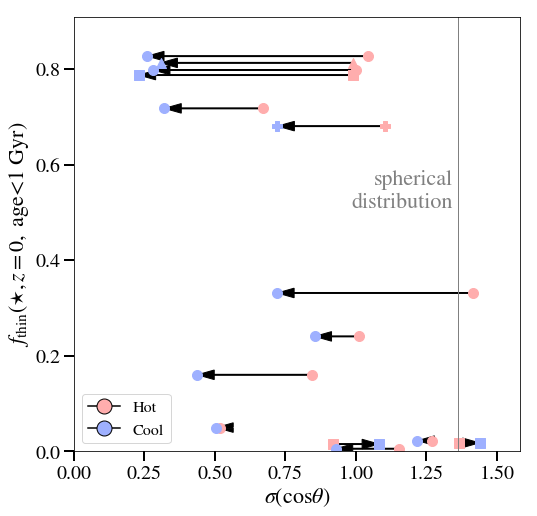

In [28]:
fig = plt.figure( figsize=(8,8), facecolor='w' )
ax = plt.gca()

x_key = 'sigma_cosphi'
y_key = 'thin_disk_frac_recent'

xs = multi_values[x_key]
xs_pre = xs.inner_item( 0 )
xs_post = xs.inner_item( -1 )
ys = values[y_key]

x_log = x_key in logscale
y_log = y_key in logscale
z_log = z_key in logscale

x_lims = get_lim( xs, x_log, x_key, 1.1 )
y_lims = get_lim( ys, y_log, y_key, 1.1 )

for key, x_pre in xs_pre.items():

    if np.isnan( x ):
        continue

    try:
        y = ys[key]
    except KeyError:
        continue

    if '_' in key:
        sim_name, physics = key.split( '_' )
    else:
        sim_name = key
        physics = ''

    # Pre
    s = ax.scatter(
        x_pre,
        y,
        s = 100,
        color = rd_bu_cmap[0],
        marker = markers[physics]
    )
    s = ax.scatter(
        xs_post[key],
        y,
        s = 100,
        color = rd_bu_cmap[-1],
        marker = markers[physics]
    )

    if annotate:
        ax.annotate(
            s = sim_name,
            xy = ( x_pre, y ),
            xytext = ( 5, 5 ),
            textcoords = 'offset points',
            fontsize = 22,
            ha = 'left',
            va = 'bottom',
        )
    
    ax.arrow(
        x_pre, y,
        xs_post[key] - x_pre, 0,
#         linewidth = 1.5,
        color = 'k',
        zorder = -100,
        width = 0.002,
        head_length = 0.06,
        head_width = 0.02,
        length_includes_head = True,
    )
    
# Reference lines
sigma_cosphi_sphere = 0.84 * 2 - 0.16 * 2
ax.axvline(
    sigma_cosphi_sphere,
    color = '.5',
    linestyle = '-',
    linewidth = 1,
)
ax.annotate(
    s = 'spherical\ndistribution',
    xy = ( sigma_cosphi_sphere, 0.6 ),
    xycoords = 'data',
    xytext = ( -5, -5 ),
    textcoords = 'offset points',
    ha = 'right',
    va = 'top',
    fontsize = 22,
    color = '.5',
)

ax.set_xlabel( labels[x_key], fontsize=22 )
ax.set_ylabel( labels[y_key], fontsize=22 )

if x_log:
    ax.set_xscale( 'log' )
if y_log:
    ax.set_yscale( 'log' )

ax.set_xlim( x_lims )
ax.set_ylim( y_lims )

# Legend
legend_labels = [ 'Hot', 'Cool' ]
legend_elements = [
Line2D([0], [0], marker='o', color='k', label=legend_labels[_], markerfacecolor=rd_bu_cmap[_], markersize=15)
for _ in [ 0, -1 ]
]
ax.legend(
handles=legend_elements,
prop = {'size': 16 },
)

plotting.save_fig(
    out_dir = os.path.join( pm['figure_dir'], 'prevalence' ),
    save_file = 'before_after_connected.pdf',
    fig = fig,
)